Adam Peetz<br>
MSDS650 Week 2 Assignment<br>
Regis University<br>

# Flights Database

The flights database is a dataset containing flight information for over 5.8 million flights. The dataset includes time information for each flight as well as arrival and destination information. The information in the database was provided by 14 major carriers. The largest service provider in the database is Southwest, with over 1 million flights. A graph of the contributions from all carriers is below.<br>
#### Business Impact: Late Flights
A flight arriving late to its destination can have big consequences for an airline. Planes schedules are created to keep assets in the air and producing at all times. With only a few minutes of downtime between scheduled flights, a late flight can cause ripple effects through a carriers network adding up to millions of dollars of lost productive time for customers and the airlines themselves.<br>

Prescriptive analysis can be performed to identify and mitigate late arrivals. A large flight dataset like the one on hand can be reviewed, and any airports that are preforming poorly can be targeted for improvement. To improve them, airports that are performing better than average can be pulled from the dataset and used as examples for the low performers.

Text(0, 0.5, 'Count of flights (millions)')

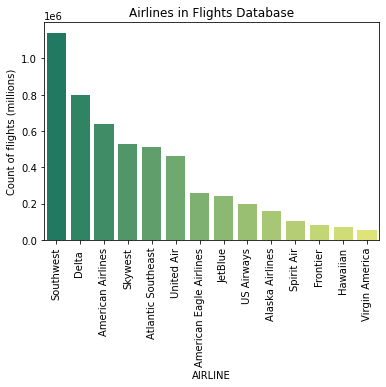

In [36]:
#barplot of number of flights in the database for each carrier.
sns.barplot(data=servergraph,x='AIRLINE',y='YEAR',palette='summer')
plt.xticks(rotation=90)
plt.title("Airlines in Flights Database")
plt.ylabel("Count of flights (millions)")

#### Index:
1) Dataset Transformations: Import and Clean the Data for Analysis <br>
2) Imputing Arrival Delay: Generating Logical Values for Blank Rows <br>
3) QQ Plot: Reviewing Data Distributions<br>
4) Probability of Delay Table: By Origin Airport<BR>
5) Worst Performing Airport: By Proportion of Late Arrivals<br>
6) Best Performing Airport: By Proportion of Late Arrivals<br>
7) Mean and STD Comparison: GST vs CNY<br>
8) Histogram Comparison: GST vs CNY<br>
9) Barplot Builder: Airline Data Count<br>

In [2]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
#import initial dataset
flights_df = pd.read_csv('assign_wk2/flights.csv', low_memory=False)

### 1) Dataset-Transformations

The airlines database was supplied in three separate CSV files. The data from all of the files was combined in pandas to allow it to be analyzed. It was combined using a combination of coded data replacements and table joins.<br>

To begin the cleaning process, all non-essential columns were dropped from the data sets. <br>

Airline information was supplied in an abbreviated format. To make this information readable, it has been replaced using a dictionary that contains the proper name for each airline in each row.<br>

I am personally interested in exploring this information in Tableau using the programs mapping features. Tableau can use both city and state and/or latitude and longitude information to draw maps. To assist with this, I have used two join statements to appended the city/state and lat/long information for the origin and destination locations on each row. <br>

Next, we look to remove unwanted rows from the database. The airports database contains numerous rows corresponding to flights to and from small airports. These can be identified and removed by scrubbing for all airports with a 5-digit code in the database. <br>
Cancelled flights have also been removed from the data set.<br>
Finally, 1 row value missing a value for SCHEDULED_TIME is dropped. SCHEDULED_TIME will be used to calculate the missing ARRIVAL_TIME values in the dataset. Removing this 1 missing value is required to all the final ARRIVAL_DELAY calculation to complete on 100% of the columns. Our data set contains 5.8 million values. Removing 1 value from such a large dataset is insignificant.<br>

In [4]:
#create list of columns to drop
drop_cols = ['TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','AIR_TIME','WHEELS_ON','TAXI_IN',\
             'CANCELLATION_REASON','AIR_SYSTEM_DELAY',\
             'SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']

#drop non-functional columns
flights_df.drop(drop_cols,axis=1,inplace=True)

#rename airlines abbreviations to generic names
flights_df['AIRLINE'] = flights_df['AIRLINE'].replace({"UA":"United Air Lines Inc." , "AA":"American Airlines Inc." ,\
                                                       "US":"US Airways Inc." , "F9":"Frontier Airlines Inc." ,\
                                                       "B6":"JetBlue Airways" ,\
                                                       "OO":"Skywest Airlines Inc." , "AS":"Alaska Airlines Inc." , \
                                                       "NK":"Spirit Air Lines" ,\
                                                       "WN":"Southwest Airlines Co." , "DL":"Delta Air Lines Inc." ,\
                                                       "EV":"Atlantic Southeast Airlines" ,\
                                                       "HA":"Hawaiian Airlines Inc.","MQ":"American Eagle Airlines Inc." ,\
                                                       "VX":"Virgin America"\
                                                      })

In [5]:
#add destination and origin information to every row
#load airport databases
destinationairports_df = pd.read_csv('assign_wk2/destination_airports.csv')
originairports_df = pd.read_csv('assign_wk2/origin_airports.csv')

#create list of columns to drop
dropairportcolumns =['AIRPORT','COUNTRY']

#drop unneeded columns from dataframes
destinationairports_df.drop(dropairportcolumns,axis=1,inplace=True)
originairports_df.drop(dropairportcolumns,axis=1,inplace=True)

#set dataframe index for join operation
destinationairports_df = destinationairports_df.set_index('IATA_CODE')
originairports_df = originairports_df.set_index('IATA_CODE')

In [6]:
#left join origin information to flights dataframe
flightport_df = flights_df.join(originairports_df,on='ORIGIN_AIRPORT',how='left')

#left join origin information to flights dataframe
flightports_df = flightport_df.join(destinationairports_df,on='DESTINATION_AIRPORT',how='left')

In [7]:
#remove minor airports from dataset
flightports_df['name_len'] = 0
flightports_df.name_len = flightports_df.ORIGIN_AIRPORT.apply(lambda x: len(str(x)))
flightports_df.drop(flightports_df[flightports_df.name_len == 5].index, inplace=True)
flightports_df.drop(['name_len'],axis=1,inplace=True)

#remove cancelled flights from dataset
flightports_df.drop(flightports_df[flightports_df.CANCELLED == 1].index, inplace = True)

#remove missing scheduled flight time flights from dataset
flightports_df.dropna(subset=['SCHEDULED_TIME'], inplace=True)

In [8]:
#sample flightports database
pd.set_option('display.max_columns', None)
flightports_df.head(1)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015,1,1,4,Alaska Airlines Inc.,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,1448,430,408.0,-22.0,0,0,Anchorage,AK,61.17432,-149.99619,Seattle,WA,47.44898,-122.30931


In [9]:
#info on flightports
flightports_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245483 entries, 0 to 5819078
Data columns (total 27 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   YEAR                   int64  
 1   MONTH                  int64  
 2   DAY                    int64  
 3   DAY_OF_WEEK            int64  
 4   AIRLINE                object 
 5   FLIGHT_NUMBER          int64  
 6   ORIGIN_AIRPORT         object 
 7   DESTINATION_AIRPORT    object 
 8   SCHEDULED_DEPARTURE    int64  
 9   DEPARTURE_TIME         float64
 10  DEPARTURE_DELAY        float64
 11  SCHEDULED_TIME         float64
 12  ELAPSED_TIME           float64
 13  DISTANCE               int64  
 14  SCHEDULED_ARRIVAL      int64  
 15  ARRIVAL_TIME           float64
 16  ARRIVAL_DELAY          float64
 17  DIVERTED               int64  
 18  CANCELLED              int64  
 19  ORIGIN_CITY            object 
 20  ORIGIN_STATE           object 
 21  ORIGIN_LATITUDE        float64
 22  ORIGIN_LONGITUDE  

### 2) Imputing Arrival Delay

To complete the project objectives arrival delay needs to be imputed for every missing value.<br>

#### ALL OF THE MISSING ARRIVAL DELAYS CORRESPOND TO DIVERTED FLIGHTS. 

My preferred way to handle this would be to drop all of the diverted flights from the dataset rather than try to impute their arrival delays. I believe the information for their arrivals is missing because the flights did not go to their destinations, they landed somewhere else. <br>

However, if I had to impute the information, I would take the scheduled arrival time and subtract the actual arrival time from it to come up with the difference. We will need to multiply this value by -1 to invert the values so that a flight arriving before the time is shown with a negative arrival delay value and one arriving after shows a positive one. This step is important for correctly classifying rows as late or on time further in the code.

To impute arrival delay using this method all the missing arrival time values need to be filled. To generate the missing arrival time, we will take the departure time and add the planes scheduled flight time to it. Scheduled time corresponded to the amount of time a flight is supposed to take and can be used to estimate the length of each missing flight.

These two operations are defined and applied to the dataset below:

In [10]:
#create impute functions

#populate missing arrival times
def fill_missing_arrival_time(row):

    if np.isnan(row.ARRIVAL_TIME):
        time = row.DEPARTURE_TIME + row.SCHEDULED_TIME
        
    else:
        time = row.ARRIVAL_TIME
        
    return time

# populate missing delays
def fill_missing_delay(row):
    delay = np.NaN
    
    if np.isnan(row.ARRIVAL_DELAY):    
        delay = (row.SCHEDULED_ARRIVAL - row.ARRIVAL_TIME)*-1
    else:
        delay = row.ARRIVAL_DELAY
        
    return delay

In [11]:
#apply impute function to arrival time
flightports_df.ARRIVAL_TIME = flightports_df.apply(lambda x: fill_missing_arrival_time(x), axis = 1)

#apply impute function to arrival delay
flightports_df.ARRIVAL_DELAY = flightports_df.apply(lambda x: fill_missing_delay(x), axis = 1)

In [12]:
#check for null values
flightports_df.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
SCHEDULED_TIME               0
ELAPSED_TIME             14353
DISTANCE                     0
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME                 0
ARRIVAL_DELAY                0
DIVERTED                     0
CANCELLED                    0
ORIGIN_CITY                  0
ORIGIN_STATE                 0
ORIGIN_LATITUDE              0
ORIGIN_LONGITUDE             0
DESTINATION_CITY             0
DESTINATION_STATE            0
DESTINATION_LATITUDE         0
DESTINATION_LONGITUDE        0
dtype: int64

### Save to CSV or Reload

Our dataset is around 1 gigabyte. To reduce its drag on ram, it can be exported to a csv file and/or be brought back in a new data frame here.

In [29]:
flightports_df.to_csv('assign_wk2/flights_cleaned.csv',index=False)

In [2]:
#import libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# import cleaned data
planedata_df = pd.read_csv('assign_wk2/flights_cleaned.csv', low_memory=False)

In [13]:
#if data already exists, start here to rename the table
planedata_df = flightports_df

### 3) QQ Plot
Is the distribution of delayed flights normally distributed?<br>
<br>
The QQ plot for arrival delay shows a close grouping to the normal distribution line around the center of the graph but a significant curve towards the edges. This pattern is indicative of a normal distribution with very heavy tails, suggesting that there are a significant number of extreme outliers in the dataset. (Ford, 2015)

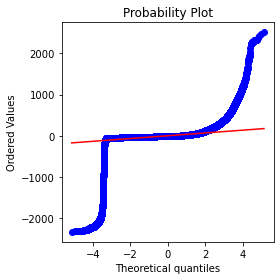

In [14]:
qqplane=planedata_df.ARRIVAL_DELAY

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(qqplane, plot=ax)

plt.tight_layout()
plt.show()

### 4) What is the probability a flight leaving from a given airport will arrive at its destination late for each airport?  

To calculate the probability of a flight leaving late we need to take the total number of late flights recorded as late for each airport and divide it by the total number of flights leaving that airport. (Hays, 2021) This can de done in the database by classifying each row as late or on time and using that classification row to count the total number of late flights for each location. To do this, a classifier function was built and passed in to the data frame to create a new "LATE_BOOL" column. The "LATE_BOOL" column can be summed to determine the total number of late flights for each location. It is also used to filter the data set to look for only information corresponding to late or on time flights.

### What is the difference between probability and proportion?
Probability refers to the chance of something occurring in the future. Proportion refers to the amount of times somethings has occurred in a dataset. (Bruce et al., 2020)

In [15]:
def label_classifier(row):
    
    if row.ARRIVAL_DELAY > 0 :
        return 1
    elif row.ARRIVAL_DELAY < 0:
        return 0

In [16]:
planedata_df['LATE_BOOL'] = planedata_df.apply(label_classifier, axis=1)

In [17]:
planedata_df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,LATE_BOOL
0,2015,1,1,4,Alaska Airlines Inc.,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,1448,430,408.0,-22.0,0,0,Anchorage,AK,61.17432,-149.99619,Seattle,WA,47.44898,-122.30931,0.0
1,2015,1,1,4,American Airlines Inc.,2336,LAX,PBI,10,2.0,-8.0,280.0,279.0,2330,750,741.0,-9.0,0,0,Los Angeles,CA,33.94254,-118.40807,West Palm Beach,FL,26.68316,-80.09559,0.0
2,2015,1,1,4,US Airways Inc.,840,SFO,CLT,20,18.0,-2.0,286.0,293.0,2296,806,811.0,5.0,0,0,San Francisco,CA,37.61900,-122.37484,Charlotte,NC,35.21401,-80.94313,1.0
3,2015,1,1,4,American Airlines Inc.,258,LAX,MIA,20,15.0,-5.0,285.0,281.0,2342,805,756.0,-9.0,0,0,Los Angeles,CA,33.94254,-118.40807,Miami,FL,25.79325,-80.29056,0.0
4,2015,1,1,4,Alaska Airlines Inc.,135,SEA,ANC,25,24.0,-1.0,235.0,215.0,1448,320,259.0,-21.0,0,0,Seattle,WA,47.44898,-122.30931,Anchorage,AK,61.17432,-149.99619,0.0


In [18]:
#create probability_df
pd.set_option('display.max_rows', None)
probability_df=planedata_df.groupby('ORIGIN_AIRPORT')['LATE_BOOL'].sum()/planedata_df.groupby('ORIGIN_AIRPORT')['LATE_BOOL'].count()

In [19]:
#sample probability_df
probability_df.head(1)

ORIGIN_AIRPORT
ABE    0.380648
Name: LATE_BOOL, dtype: float64

### 5) Determine the originating airport with the largest proportion of flights arriving late to their destination.

The originating airport with the highest proportion of late flights is GST, which is in Gustavus Alaska. Gustavus only has flight service to Juneau Alaska. If you are flying Gustavus to Juneau, you have a 67% chance of arriving late to your destination.

In [20]:
#most late flights
probability_df.sort_values(ascending=False).head(5)

ORIGIN_AIRPORT
GST    0.671053
PPG    0.647619
ADK    0.636364
ILG    0.576087
AKN    0.516129
Name: LATE_BOOL, dtype: float64

### 6) Determine the originating airport with the smallest proportion of flights arriving late to their destination. 
The originating airport with the smallest proportion of late flights is CNY, which is in Moab Utah. Like Gustavus, Moab only has flights going to one location, Salt Lake City. However, unlike Gustavus, flights out of the Moab airport are only late 4% of the time

In [21]:
#least late flights
probability_df.sort_values(ascending=True).head(5)

ORIGIN_AIRPORT
CNY    0.039024
VEL    0.117949
BTM    0.155172
LWS    0.170175
DIK    0.212953
Name: LATE_BOOL, dtype: float64

### 7) What is the mean and std of late arrival times for both of these airports.

Mean<br>
Gustavus: 36.2<br>
Moab:22.7<br>

Std<BR>
Gustavus: 39.08<br>
Moab:22.4 <br>
    
The mean and standard deviation of the late arrival delays can also be used to judge how both airports perform when they are running late. Here we are filtering out all on time flights with the hope of understanding, if you are late, just how late will you be. To get to this information the dataset was filtered to exclude all rows of on time flights. 
    
Moab performs better when it is running late. With a mean and standard deviation around 22, you would have to be incredibly unlucky to spend more than 1 hour waiting for a flight. Gustavus however, has a mean lateness and standard dev of 36.2 and 39. When Gustavus is running late, it is really running late. You are probably going to spend close to an hour waiting for that late flight.

In [22]:
#filter for late flights
lateonlydf = planedata_df.drop(planedata_df[planedata_df.LATE_BOOL == 0].index)

In [23]:
#group by mean
mean_df = lateonlydf.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].mean()

In [24]:
#show mean of GST
mean_df['GST']

36.21568627450981

In [25]:
#show mean of CNY
mean_df['CNY']

22.75

In [26]:
#grou by standard deviation
std_df = lateonlydf.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].std()

In [27]:
#show std of GST
std_df['GST']

39.086219426027995

In [28]:
#show std of CNY
std_df['CNY']

22.429253856769925

### 8) Use these two airports and compare their histograms of arrival delays with each other.  Which airport seems like you would have a better chance at arriving at your destination on time? 

To visualize how both airports perform, the arrival times have been called into a histograph for both locations. The histograph paints a clear pattern of performance for each airport and reinforces Moab as the better performer. The histogram for Moab shows the majority of its flights actually arrive in Salt Lake ahead of schedule. While Gustavus does occasionally have flights arrive ahead, its arrival times have an extremely long tail showing some flights with huge delays, upwards of 175 minutes

In [1]:
#filter for GST flight data
gstdata_df = planedata_df[planedata_df['ORIGIN_AIRPORT']=='GST']

NameError: name 'planedata_df' is not defined

Text(0.5, 0, 'Arrival Delay')

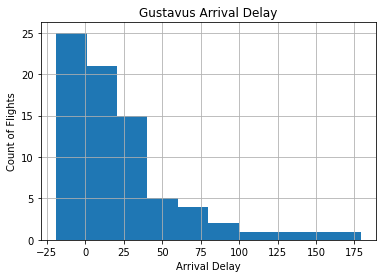

In [30]:
#create GST graph
gstdata_df.hist(column='ARRIVAL_DELAY')
plt.title('Gustavus Arrival Delay')
plt.ylabel("Count of Flights")
plt.xlabel("Arrival Delay")

In [31]:
#filter for CNY flight data
cnydata_df = planedata_df[planedata_df['ORIGIN_AIRPORT']=='CNY']

Text(0.5, 0, 'Arrival Delay')

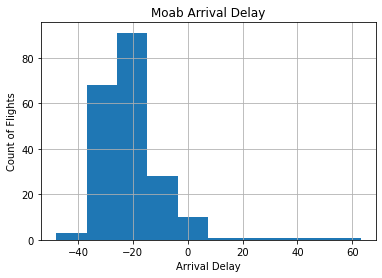

In [32]:
#draw CNY graph
cnydata_df.hist(column='ARRIVAL_DELAY')
plt.title('Moab Arrival Delay')
plt.ylabel("Count of Flights")
plt.xlabel("Arrival Delay")

### Barplot Code:

Create a graph to visualize the number of flights in the database and the carriers. Used for exposition.

In [33]:
#count and name and sort
servergraph = planedata_df.groupby('AIRLINE').count()
servergraph['AIRLINE'] = ['Alaska Airlines','American Airlines','American Eagle Airlines','Atlantic Southeast','Delta ',\
                         'Frontier','Hawaiian','JetBlue','Skywest','Southwest','Spirit Air','US Airways','United Air','Virgin America']
servergraph.sort_values(by='YEAR',inplace=True,ascending=False)

Text(0, 0.5, 'Count of flights (millions)')

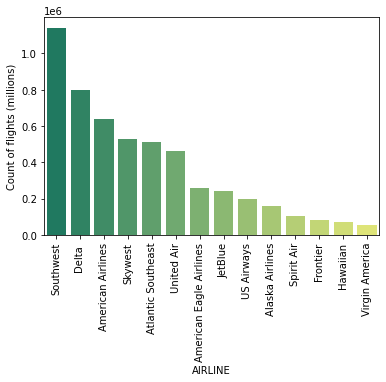

In [34]:
#create graph
sns.barplot(data=servergraph,x='AIRLINE',y='YEAR',palette='summer')
plt.xticks(rotation=90)
plt.ylabel("Count of flights (millions)")

## References

Bruce, P., Bruce, A. G., &amp; Gedeck, P. (2020). Practical statistics for data scientists: 50+ essential concepts using r and python. O'Reilly. 

Ford, Clay. (2015, August 26). Understanding Q-Q Plots. Retrieved from https://data.library.virginia.edu/understanding-q-q-plots/

Hays, Genie. (2021, October 30). Week 2: Calculating Probability. Retrieved from https://worldclass.regis.edu/d2l/le/news/277913/721581/view?ou=277913

